# Libraries

In [1]:
!pip install currencyconverter

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python -m pip install --upgrade pip' command.


In [2]:
from minio import Minio
import duckdb
import pandas as pd
import numpy as np

In [3]:
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torchvision.transforms import transforms
import torch.nn as nn
import torch
from transformers import BertModel, RobertaModel, DistilBertModel
from torchvision.models import resnet50
from torch import cuda
from PIL import Image
import time
from transformers import RobertaForSequenceClassification, RobertaTokenizer
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer
from torchvision import models
import torch.nn.functional as F

In [4]:
from io import BytesIO

In [5]:
ACCESS_KEY = "RkX19daoA4QpeUytwGna"
SECRET_ACCESS_KEY = "jIr2nk8MPaT6xUn5p9qFuSZISg36ykrqXlP2lyjs"
STORAGE_OPTIONS = {
        "key": ACCESS_KEY,
        "secret": SECRET_ACCESS_KEY,
        "endpoint_url": "http://minio-api-svc"}

client = Minio(
    "minio-api-svc",
    access_key=ACCESS_KEY,
    secret_key=SECRET_ACCESS_KEY,
    secure=False
)
connection = duckdb.connect()
connection.execute("INSTALL httpfs")
connection.execute("LOAD httpfs")
connection.execute("SET s3_region='us-east-1'")
connection.execute("SET s3_access_key_id='KhjA5yMeOPzDWDyh'")
connection.execute("SET s3_secret_access_key='PTzHBYNc1HmO3TNdKN3IjUIJx3Q5VS5m'")
connection.execute("SET s3_endpoint='minio-api-svc';")
connection.execute("SET s3_use_ssl=false")
connection.execute("SET s3_url_style=path")


# Data import

In [6]:
df = pd.read_parquet("file.parquet")

In [7]:
# remove all data without image_path
df = df[~df["image_path"].isnull()]
# use only ads that has price info
# df = df[~df["price"].isnull()]
# use only ads with labels
# df = df[~df["predicted_label"].isnull()]

In [8]:
bucket_name_images = "images-november"

In [9]:
df.columns

Index(['url', 'title', 'text', 'domain', 'name', 'description', 'image',
       'retrieved', 'production_data', 'category', 'price', 'currency',
       'seller', 'seller_type', 'seller_url', 'location', 'ships to', 'id',
       'loc_name', 'lat', 'lon', 'country', 'image_path', 'predicted_label'],
      dtype='object')

Model Accuracy: 0.8333333333333334


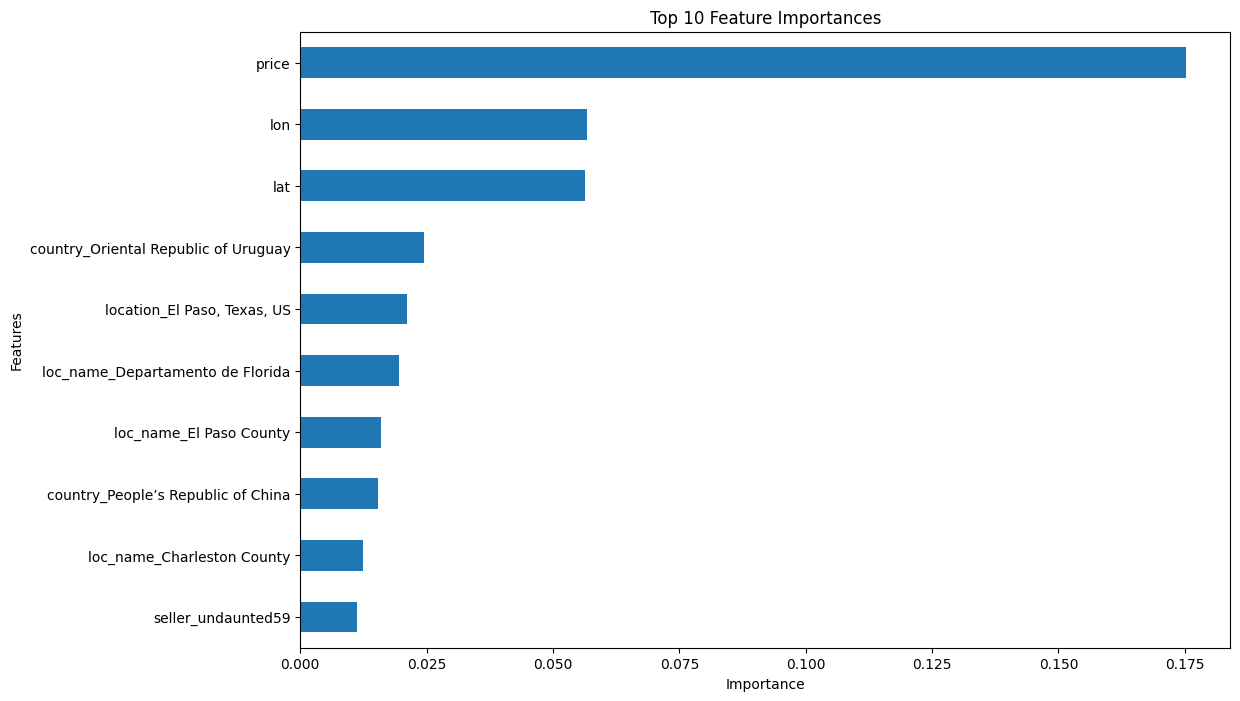

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

target = 'predicted_label'
numerical_cols = ['price', 'lat', 'lon']
categorical_cols = ['category', 'currency', 'country', 'seller', 'location', 'loc_name', 'ships to']
categorical_transformer = OneHotEncoder(handle_unknown='ignore', drop=None)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

column_names_for_X = ['price', 'lat', 'lon', 'category', 'currency', 'country', 
                      'seller', 'location', 'loc_name', 'seller_type', 'ships to']
df_clean = df.dropna(subset=column_names_for_X)


X = df_clean.drop(columns=['predicted_label', 'id', 'image_path', 'title', 'description', 
                           'domain', 'image', 'url', 'retrieved', 'name'])
y = df_clean['predicted_label']
# X = df.drop(columns=[target, 'id', 'image_path', 'title', 'text', 
#                      'description', 'domain', 'image', 'url', 'retrieved', 'production_data', 'name', 'seller_url', 'path'])
# y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Model Accuracy:", accuracy)

feature_importances = model.named_steps['classifier'].feature_importances_

onehot_columns = model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(onehot_columns)

importances = pd.Series(feature_importances, index=feature_names)

# Plot feature importances
# plt.figure(figsize=(12,8))
# importances.sort_values().plot(kind='barh')
# plt.title('Feature Importance')
# plt.xlabel('Importance')
# plt.ylabel('Features')
# plt.show()

top_10_importances = importances.sort_values(ascending=True).tail(10)

# Create the plot
plt.figure(figsize=(12, 8))
top_10_importances.plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

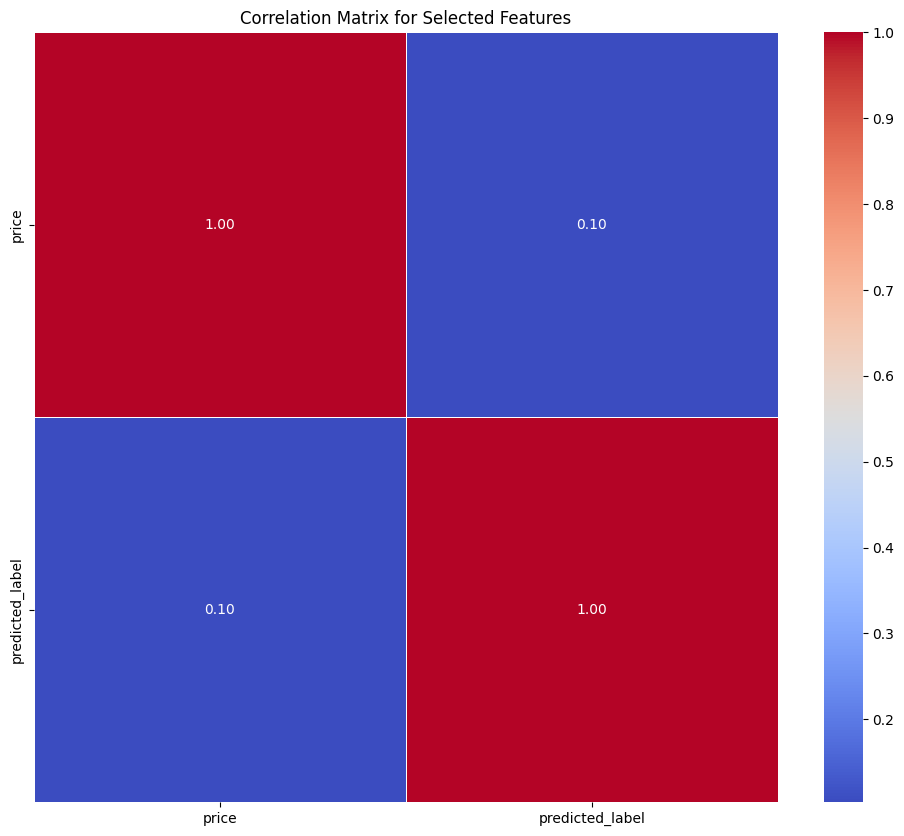

In [11]:
import seaborn as sns
import pandas as pd

selected_columns = ['price','predicted_label']
df_selected = df_clean[selected_columns]
# categorical_columns = ['seller_type']
# df_encoded = pd.get_dummies(df_selected, columns=categorical_columns)
correlation_matrix = df_selected.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix for Selected Features')
plt.show()

# Data cleaning

In [12]:
import pandas as pd
import numpy as np

# Updated mapping dictionary
mapping_dict = {
    'US': 'United States', 'USA': 'United States', 'CN': 'China', 'CA': 'Canada', 'SG': 'Singapore',
    'GB': 'United Kingdom', 'UK': 'United Kingdom', 'Great Britain': 'United Kingdom', 'FR': 'France', 
    'DE': 'Germany', 'BY': 'Belarus', 'LA': 'Laos', 'CH': 'Switzerland', 'PA': 'Panama', 
    'MI': 'United States', 'NL': 'Netherlands', 'IT': 'Italy', 'GA': 'United States', 'MD': 'United States', 
    'NY': 'United States', 'JP': 'Japan', 'SI': 'Slovenia', 'AM': 'Armenia', 'DK': 'Denmark',
    'FL': 'United States', 'TX': 'United States', 'AT': 'Austria', 'PT': 'Portugal', 'BE': 'Belgium',
    'PL': 'Poland', 'TR': 'Turkey',
    '美国': 'United States', '英国': 'United Kingdom', '意大利': 'Italy', '法国': 'France',
    'США': 'United States', 'Reino Unido': 'United Kingdom', 'Estados Unidos': 'United States',
    'Украина': 'Ukraine', 'Великобритания': 'United Kingdom', 'España': 'Spain', 'Германия': 'Germany', 'Francia': 'France',
    'Italia': 'Italy', 'Itália': 'Italy', 'Кипр': 'Cyprus', 'Alemania': 'Germany', 'Alemanha': 'Germany', 'Ucrania': 'Ukraine',
    'França': 'France', 'Canadá': 'Canada',
}

def extract_and_convert_country(location):
    if pd.isna(location):
        return np.nan
    parts = location.split(',')
    if len(parts) > 1:
        country_candidate = parts[-1].strip()
        # Return the full country name using the dictionary, default to the candidate if not found
        return mapping_dict.get(country_candidate, country_candidate)
    else:
        return np.nan

    
df['country'] = df['location'].apply(extract_and_convert_country)

In [13]:
#optional:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

geolocator = Nominatim(user_agent="geoapiExercises")

def get_country(lat, lon):
    try:
        # Check if latitude and longitude are valid
        if pd.isna(lat) or pd.isna(lon):
            return None
        
        # Ensure lat and lon are floats (necessary if the data type might be object or string)
        lat, lon = float(lat), float(lon)

        # Perform reverse geocoding
        location = geolocator.reverse((lat, lon), exactly_one=True)
        if location:
            address = location.raw.get('address', {})
            country = address.get('country', None)
            return country
        return None
    except GeocoderTimedOut:
        return None  # Return None if geocoder times out
    except Exception as e:
        print(f"Error occurred: {e}")
        return None  # Return None for any other error

def fill_country(row):
    if pd.isna(row['country']):
        return get_country(row['lat'], row['lon'])
    else:
        return row['country']

df['country'] = df.apply(fill_country, axis=1)

Error occurred: Non-successful status code 403
Error occurred: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /reverse?lat=54.75844&lon=-2.69531&format=json&addressdetails=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))


In [14]:
# df = pd.read_csv("data_labeled_feb_7_2024.csv")
df["path"] = df["image_path"]
#df["label"] = np.where(df.relevant == "animal origin", 1, 0)
df = df.dropna(subset = ["title"])

In [15]:
df['country'].unique()

array(['United States', 'China', 'Denmark', 'Italy', 'Japan', 'Canada',
       'United Kingdom', 'Slovenia', 'Germany', 'Armenia', 'Belarus',
       'France', 'Singapore', None, 'Laos', 'Panama', 'Switzerland',
       'Netherlands', 'Austria', 'Portugal', 'Belgium', 'Poland',
       'Turkey', 'Sweden', 'Vietnam', 'Finland', 'Lithuania', 'Hong Kong',
       'Philippines', 'Australia', 'Malaysia', 'Chile', 'Indonesia',
       'Egypt', 'Romania', 'Spain', 'Bulgaria', 'Cyprus', 'Ukraine',
       'Sri Lanka', 'Filipinas', 'Lituania', 'India', 'Thailand',
       'Latvia'], dtype=object)

## Currency converter

In [16]:
from currency_converter import CurrencyConverter


In [17]:
currency_list = df['currency'].unique()
currency_list = list(currency_list)
currency_list = [i for i in currency_list if not i == 'None']
print(currency_list)

['USD', 'CAD', 'PYG', 'PEN', 'BOB', 'EUR', 'DOP', 'COP', 'CNY', 'CRC', 'CLP', 'HNL', 'MXN', 'BRL', 'ILS', 'UYU', 'NIO', 'GTQ', 'HKD', 'PHP']


In [18]:
c = CurrencyConverter()
n= len(currency_list)
exchange_rates ={
'BOB':0.14,
'BDP':0.17,
'COP':0.00026,
'GTQ':0.13,
'HNL':0.041,
'PEN':0.27,
'PYG':0.00013,
'DOP':0.017,
'CRC':0.0020,
'CLP':0.0011,
'UYU':0.026,
'NIO':0.027,
}
for i in currency_list:
    if(i not in exchange_rates.keys()):
        exchange_rates[i] = c.convert(1,'USD',i)
        
print(exchange_rates)

{'BOB': 0.14, 'BDP': 0.17, 'COP': 0.00026, 'GTQ': 0.13, 'HNL': 0.041, 'PEN': 0.27, 'PYG': 0.00013, 'DOP': 0.017, 'CRC': 0.002, 'CLP': 0.0011, 'UYU': 0.026, 'NIO': 0.027, 'USD': 1.0, 'CAD': 1.3689121104683708, 'EUR': 0.9330098899048329, 'CNY': 7.240996454562418, 'MXN': 16.970983392423957, 'BRL': 5.124836723269266, 'ILS': 3.7480873297256947, 'HKD': 7.8202089942153385, 'PHP': 57.688001492815815}


In [19]:
def convert_to_usd(row):
    currency = row['currency']
    amount = row['price']
    rate = exchange_rates.get(currency, None)
    if rate is None:
        return None
    return amount * rate


In [20]:
df['price_usd'] = df.apply(convert_to_usd, axis=1)

In [21]:
df[['currency','price','price_usd']]

,currency,price,price_usd
0,USD,2.50,2.500000
1,USD,4.99,4.990000
2,USD,50.00,50.000000
3,USD,14.99,14.990000
4,USD,179.00,179.000000
...,...,...,...
1669,PHP,1102.28,63588.330286
1670,PHP,1892.40,109168.774025
1671,PHP,1892.40,109168.774025
1672,PHP,1286.37,74208.114480


## Dropping unwanted columns

In [22]:
df = df.drop(['price','currency'], axis=1)

In [23]:
# construct a country array to tokenize countries
countries = df.country.unique()
# droping data will null price or country
df = df[~df["price_usd"].isnull()]
df = df[~df["country"].isnull()]

In [24]:
# For normalizing price
max_price = df.price_usd.max()

# Feature Engineering

## Data visualizations for Hypothesis testing
Visualize data distribution of features for understanding feature importance and generate/drop features

In [25]:
# We will first prepare the dataset for inference
class InferenceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, transform=None):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['description']
        img_path = row['path']
        label = float(row["predicted_label"])
        price = row['price_usd']
        country = row['country']
        
        # Processing text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        # GETTING DATA FROM MINIO
        object_name = img_path
        image_data = client.get_object(bucket_name_images, object_name)
        image_bytes = image_data.read()
        image = Image.open(BytesIO(image_bytes)).convert("RGB")
        
        # Processing images
        # image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'image': image,
            'label': [1-label, label],
            'price': np.array([price/max_price]).astype(np.float32),
            'country': np.array([np.where(countries == country)[0][0]/len(countries)]).astype(np.float32)
        }


In [26]:
# Combine text fields
# df['path'] = "local_images/" + df['image_path']

In [27]:
# Constants
MAX_LEN = 128
BATCH_SIZE = 16

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

# Prepare dataset and dataloader for inference
inference_dataset = InferenceDataset(
    dataframe=df,
    tokenizer=tokenizer,  
    max_len=MAX_LEN,
    transform=transform,
)

# Train test split
train_size = int(0.8 * len(inference_dataset))
test_size = len(inference_dataset) - train_size
train_dataset, test_dataset = random_split(inference_dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader =  DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [28]:
text = DistilBertModel.from_pretrained('distilbert-base-uncased')

img = models.efficientnet_v2_m(pretrained=True)

class MultiHeadCrossAttention(nn.Module):
    def __init__(self, text_dim, image_dim, num_heads, hidden_dim, output_dim):
        super(MultiHeadCrossAttention, self).__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        # These linear layers project the inputs to multiple heads
        self.text_query = nn.Linear(text_dim, hidden_dim, bias=False)
        self.text_key = nn.Linear(text_dim, hidden_dim, bias=False)
        self.text_value = nn.Linear(text_dim, hidden_dim, bias=False)

        self.image_query = nn.Linear(image_dim, hidden_dim, bias=False)
        self.image_key = nn.Linear(image_dim, hidden_dim, bias=False)
        self.image_value = nn.Linear(image_dim, hidden_dim, bias=False)

        # Final projection layer
        self.out_proj = nn.Linear(hidden_dim, output_dim, bias=False)

    def forward(self, text_features, image_features):
        Q_text = self.text_query(text_features)
        K_text = self.text_key(text_features)
        V_text = self.text_value(text_features)

        Q_image = self.image_query(image_features)
        K_image = self.image_key(image_features)
        V_image = self.image_value(image_features)

        # Split the hidden dimension into num_heads
        Q_text = Q_text.view(Q_text.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        K_text = K_text.view(K_text.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        V_text = V_text.view(V_text.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)

        Q_image = Q_image.view(Q_image.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        K_image = K_image.view(K_image.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        V_image = V_image.view(V_image.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Calculate the attention scores
        attn_scores_text_image = torch.matmul(Q_text, K_image.transpose(-1, -2)) / (self.head_dim ** 0.5)
        attn_scores_image_text = torch.matmul(Q_image, K_text.transpose(-1, -2)) / (self.head_dim ** 0.5)

        # Normalize scores
        attn_probs_text_image = F.softmax(attn_scores_text_image, dim=-1)
        attn_probs_image_text = F.softmax(attn_scores_image_text, dim=-1)

        # Apply attention
        attn_output_text_image = torch.matmul(attn_probs_text_image, V_image)
        attn_output_image_text = torch.matmul(attn_probs_image_text, V_text)

        # Concatenate the results across the heads
        attn_output_text_image = attn_output_text_image.transpose(1, 2).contiguous().view(text_features.size(0), -1)
        attn_output_image_text = attn_output_image_text.transpose(1, 2).contiguous().view(image_features.size(0), -1)

        # Project to output dimension
        output_text_image = self.out_proj(attn_output_text_image)
        output_image_text = self.out_proj(attn_output_image_text)

        return output_text_image, output_image_text


class MultiModalModel(nn.Module):
            def __init__(self, num_labels):
                super(MultiModalModel, self).__init__()

                # Load pre-trained models
                self.bert = text
                self.resnet = img

                # Remove the final classification layer of ResNet
                self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
                self.mhca = MultiHeadCrossAttention(text_dim=768, image_dim=1280, num_heads=4, hidden_dim=512, output_dim=2048)
                
                self.classifier = nn.Sequential(
                    nn.Linear(2818, 512), 
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(512, num_labels)
                )

            def forward(self, input_ids, attention_mask, image, price, country):
                # Forward pass through BERT
                outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
                text_features = outputs['last_hidden_state'][:, 0, :]  # CLS token output as text feature
                
                # Forward pass through ResNet
                image_features = self.resnet(image)
                image_features = image_features.view(image_features.size(0), -1)  # Flatten the output
                
                if text_features.dim() == 2:
                    text_features = text_features.unsqueeze(1)
                if image_features.dim() == 2:
                    image_features = image_features.unsqueeze(1)
                
                attended_text, attended_image = self.mhca(text_features, image_features)
                
                attended_text = attended_text.squeeze(1)  # shape: [16, 768]
                attended_image = attended_image.squeeze(1) # shape: [16, 2048]

                self.image_projection = torch.nn.Linear(2048, 768).to(device)
                attended_image = self.image_projection(attended_image)
                combined_features = torch.cat((attended_text, attended_image, price, country), dim=-1)

                logits = self.classifier(combined_features)

                return logits



/home/jovyan/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jovyan/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [29]:
import urllib3, socket
from urllib3.connection import HTTPConnection

HTTPConnection.default_socket_options = ( 
    HTTPConnection.default_socket_options + [
    (socket.SOL_SOCKET, socket.SO_SNDBUF, 1000000), #1MB in byte
    (socket.SOL_SOCKET, socket.SO_RCVBUF, 1000000)
])

## Training

In [30]:
def train_one_epoch_inference(model, dataloader, optimizer, loss_fn, device):
    model.train()
    correct = 0
    tot_loss = 0
    
    for batch in dataloader:
        # Zero your gradients for every batch
        optimizer.zero_grad()
        
        # Putting all data into device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        image = batch['image'].to(device)
        label = torch.stack(batch['label'], 1).to(device)
        price = batch['price'].to(device)
        country = batch['country'].to(device)
            
        # Compute loss and gradients
        outputs = model(input_ids, attention_mask, image, price, country)
        loss = loss_fn(outputs, label)
        loss.backward()
        
        # Adjust weights
        optimizer.step()
        
        # accumulate loss and accuracy for data
        outputs = torch.argmax(outputs, dim=1)
        labels = torch.argmax(label, dim=1)
        correct += (outputs == labels).float().sum().item()
        tot_loss += loss.item()
    
    return round(tot_loss / len(dataloader.dataset), 4), round(100 * correct / len(dataloader.dataset), 2)
    

In [31]:
# Model elements
model = MultiModalModel(num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"working on {device}")
model.to(device)

# can be adjusted
learning_rate = 0.001
num_epochs = 20

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

loss_fn = torch.nn.CrossEntropyLoss()

losses = []
accuracy = []

start_time = time.time()
for i in range(num_epochs):
    loss, acc = train_one_epoch_inference(model, train_dataloader, optimizer, loss_fn, device)
    losses.append(loss)
    accuracy.append(acc)
    print(f"Loss: {loss}, Accuracy: {acc}%")
    end_time = time.time()
    print(f"Training epoch {i} took {end_time-start_time:.2f} seconds")
    start_time = end_time

working on cpu
Loss: 0.042, Accuracy: 63.6%
Training this epoch took 194.75 seconds
Loss: 0.0375, Accuracy: 69.87%
Training this epoch took 187.79 seconds
Loss: 0.0358, Accuracy: 69.87%
Training this epoch took 194.05 seconds
Loss: 0.0328, Accuracy: 69.87%
Training this epoch took 184.52 seconds
Loss: 0.03, Accuracy: 72.38%
Training this epoch took 182.53 seconds
Loss: 0.0257, Accuracy: 80.06%
Training this epoch took 188.67 seconds
Loss: 0.0218, Accuracy: 87.45%
Training this epoch took 184.80 seconds
Loss: 0.0203, Accuracy: 87.59%
Training this epoch took 183.94 seconds
Loss: 0.0147, Accuracy: 92.19%
Training this epoch took 184.12 seconds
Loss: 0.0126, Accuracy: 92.89%
Training this epoch took 184.49 seconds
Loss: 0.0103, Accuracy: 93.86%
Training this epoch took 189.18 seconds
Loss: 0.008, Accuracy: 95.68%
Training this epoch took 187.08 seconds
Loss: 0.0072, Accuracy: 95.96%
Training this epoch took 266.32 seconds
Loss: 0.005, Accuracy: 97.07%
Training this epoch took 222.53 secon

## Testing

In [45]:
# Function to run inference
def run_inference(model, dataloader, device):
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            price = batch['price'].to(device)
            country = batch['country'].to(device)
            
            outputs = model(input_ids, attention_mask, images, price, country)
            
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            labels.extend(torch.argmax(torch.stack(batch['label'], 1), dim=1).numpy())
    
    return predictions, labels


In [33]:
start_time = time.time()
s
# Get the predictions
predictions, true_labels = run_inference(model, test_dataloader, device)

end_time = time.time()

elapsed_time = end_time - start_time
print(f"Inference took {elapsed_time:.2f} seconds")

Inference took 16.00 seconds


In [34]:
## TEST SET

In [35]:
def check_performance(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    cm=confusion_matrix(y_true, y_pred)
    return cm

In [36]:
cf_matrix = check_performance(predictions, true_labels)

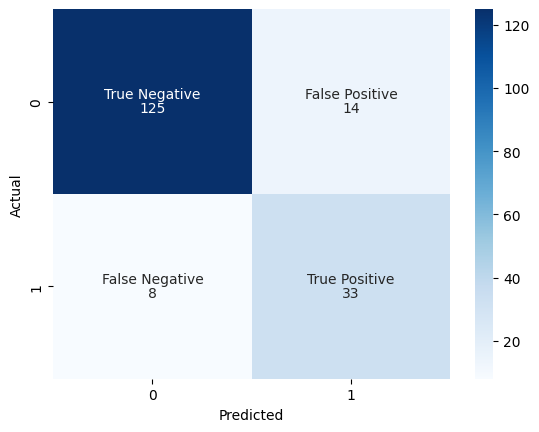

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a list of labels for each cell in the confusion matrix
labels = [['True Negative', 'False Positive'],
          ['False Negative', 'True Positive']]

# Create the heatmap with labels
# sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')
sns.heatmap(cf_matrix, annot=labels, annot_kws={'va':'bottom'}, fmt="", cmap='Blues')
sns.heatmap(cf_matrix, annot=True, annot_kws={'va':'top'}, fmt="", cmap='Blues',  cbar=False)
# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the plot
plt.show()

In [38]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

In [39]:
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
accuracy = accuracy_score(true_labels, predictions)
f"Precision: {recall} Recall: {precision}, accuracy: {accuracy}"

'Precision: 0.7021276595744681 Recall: 0.8048780487804879, accuracy: 0.8777777777777778'

In [40]:
## TRAINING SET

In [41]:
predictions2, true_labels2 = run_inference(model, train_dataloader, device)

In [42]:
cf_matrix2 = check_performance(predictions2, true_labels2)

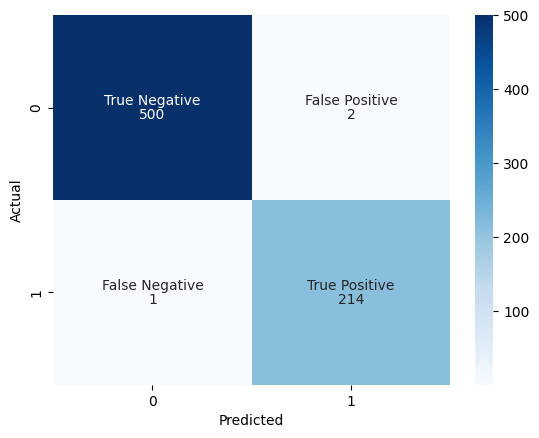

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a list of labels for each cell in the confusion matrix
labels = [['True Negative', 'False Positive'],
          ['False Negative', 'True Positive']]

# Create the heatmap with labels
# sns.heatmap(cf_matrix, annot=True, fmt='', cmap='Blues')
sns.heatmap(cf_matrix2, annot=labels, annot_kws={'va':'bottom'}, fmt="", cmap='Blues')
sns.heatmap(cf_matrix2, annot=True, annot_kws={'va':'top'}, fmt="", cmap='Blues',  cbar=False)
# Set the axis labels
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Display the plot
plt.show()

In [44]:
precision2 = precision_score(true_labels2, predictions2)
recall2 = recall_score(true_labels2, predictions2)
accuracy2 = accuracy_score(true_labels2, predictions2)
f"Precision: {recall2} Recall: {precision2}, accuracy: {accuracy2}"

'Precision: 0.9907407407407407 Recall: 0.9953488372093023, accuracy: 0.99581589958159'